
# <span style="color:red"> ***** </span><span style="color:blue"> MFCC (Mel-Frequency Cepstral Coefficients)</span> <span style="color:green"> ***** </span>

Librosa's MFCC feature extraction function librosa.feature.mfcc() includes most of the steps in the MFCC extraction process, but not all of them. Here's a breakdown:

Pre-emphasis: Not included, but can be applied separately if needed.

Framing: Handled internally.

Windowing: Handled internally.

Fast Fourier Transform (FFT): Handled internally.

Mel filterbank: Handled internally.

Logarithm: Handled internally.

Discrete Cosine Transform (DCT): Handled internally.

Delta and Delta-Delta: Not included, but can be computed separately.

# <span style="color:red"> ***** </span><span style="color:blue"> Project Data File Folder</span> <span style="color:green"> ***** </span>

In [1]:
import sys, os
parent_dir = os.path.dirname(os.path.realpath('/Users/akpy27/Downloads/Untitled'))
# To get one directory up from the current file
project_dir = os.path.abspath(os.path.join(parent_dir, "./Untitled/"))

sys.path.insert(0,project_dir)

print ('Parent Directory Path:', parent_dir)
print ('Project Path:', project_dir)

Parent Directory Path: /Users/akpy27/Downloads
Project Path: /Users/akpy27/Downloads/Untitled



# <span style="color:red"> ***** </span><span style="color:blue"> MFCC Feature Extraction</span> <span style="color:green"> ***** </span>

In [2]:
!pip install noisereduce

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import librosa
import torchaudio
import numpy as np
from glob import glob
from tqdm import tqdm
import soundfile as sf
import noisereduce as nr

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

def extract_feature(audio_file, n_mfcc=13, preprocess=False, noise=False):

  '''
  Function to extract features from a single audio file given its path
  Modify this function to extract your own custom features
  '''

  audio,fs = torchaudio.load(audio_file)
  audio = audio.numpy().reshape(-1)

  if preprocess:
    #write code to do preprocessing - scipy, librosa
    audio = librosa.resample(audio, orig_sr=44100, target_sr=16000)

  if noise:
    y_preemphasized = librosa.effects.preemphasis(y=audio)
    #reduced_noise = nr.reduce_noise(y_preemphasized,sr=fs)
    mfccs = librosa.feature.mfcc(y=y_preemphasized, sr=fs, n_mfcc=n_mfcc)
  else:
    mfccs = librosa.feature.mfcc(y=audio, sr=fs, n_mfcc=n_mfcc)


  # replace the following features with your own - audiomentations, spafe
  
  delta1 = mfccs[:-1] - mfccs[1:]
  delta2 = delta1[:-1] - delta1[1:]

  mfccs = np.concatenate((mfccs, delta1, delta2))
  #gtcc (gfcc), pncc
  #whitening filter, spectral gating filter
  feat_out = np.mean(mfccs,axis=1)

  return feat_out




In [5]:
def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DCB' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  elif 'DTA' in file_name:
    label=5
  else:
    raise ValueError('invalid file name')
  return label

# <span style="color:red"> ***** </span><span style="color:blue"> Train and Test Data Preparation</span> <span style="color:green"> ***** </span>

In [6]:

#First we obtain the list of all files in the train directory
train_files = glob(project_dir + "/project_data/train/*.wav")

#Let's sort it so that we're all using the same file list order
#and you can continue processing the features from a given file if it stops
#partway through running
train_files.sort()

train_feat=[]
train_label=[]

for wav in tqdm(train_files):

  train_feat.append(extract_feature(wav))
  train_label.append(get_label(wav))

100%|██████████| 8980/8980 [16:02<00:00,  9.33it/s]


In [7]:
#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob(project_dir + '/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort()

test_clean_feat=[]
test_clean_label=[]

for wav in tqdm(test_clean_files):

  test_clean_feat.append(extract_feature(wav))
  test_clean_label.append(get_label(wav))

  0%|          | 0/2533 [00:00<?, ?it/s]

100%|██████████| 2533/2533 [05:18<00:00,  7.95it/s]


In [8]:
#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob(project_dir + '/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort()

test_noisy_feat=[]
test_noisy_label=[]

for wav in tqdm(test_noisy_files):
  test_noisy_feat.append(extract_feature(wav, noise=True))
  test_noisy_label.append(get_label(wav))

100%|██████████| 3238/3238 [07:14<00:00,  7.45it/s]



# <span style="color:red"> ***** </span><span style="color:blue"> Model Training and Predictions</span> <span style="color:green"> ***** </span>

In [9]:
import xgboost
import numpy as np
import shap
import pandas as pd

#Format input data

#Edit this variable to create a list that contains your feature names
feat_names=['mfcc_' +str(n) for n in range(len(train_feat[0]))]

train_feat_df = pd.DataFrame(data=np.stack(train_feat), columns=feat_names)
y_train=np.stack(train_label)


test_clean_feat_df = pd.DataFrame(data=np.stack(test_clean_feat), columns=feat_names)
y_test_clean=np.stack(test_clean_label)


test_noisy_feat_df = pd.DataFrame(data=np.stack(test_noisy_feat), columns=feat_names)
y_test_noisy=np.stack(test_noisy_label)


#you could just pass in the matrix of features to xgboost
#but it looks prettier in the shap explainer if you format it
#as a dataframe.


model = xgboost.XGBClassifier()
model.fit(train_feat_df,y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))


Train Clean Acc = 1.0
Test Clean Acc = 0.518752467429925
Test Noisy Acc = 0.5003088326127239


# <span style="color:red"> ***** </span><span style="color:blue"> Interpreting Results and Explainability</span> <span style="color:green"> ***** </span>

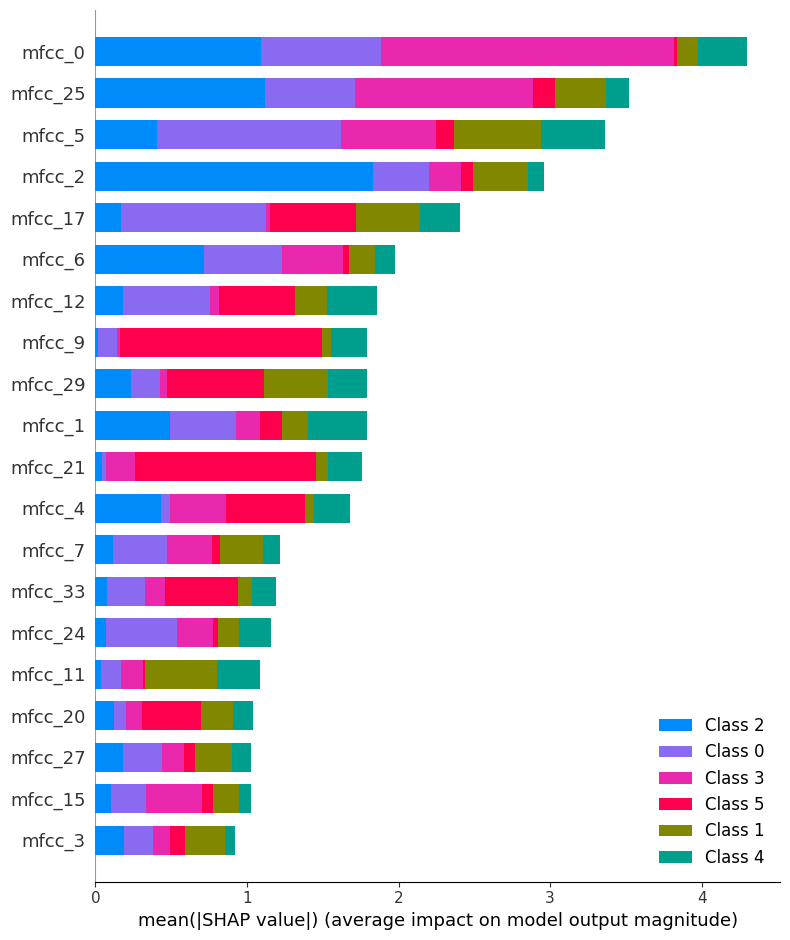

In [10]:
import shap

# Explain the model's predictions using SHAP by computing SHAP values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(train_feat_df)

#Convert the shap values for each class to a single list
shap_as_list=[]
for i in range(6):
    shap_as_list.append(shap_values[:,:,i])

# Plot the SHAP values
shap.summary_plot(shap_as_list, train_feat_df, plot_type="bar")

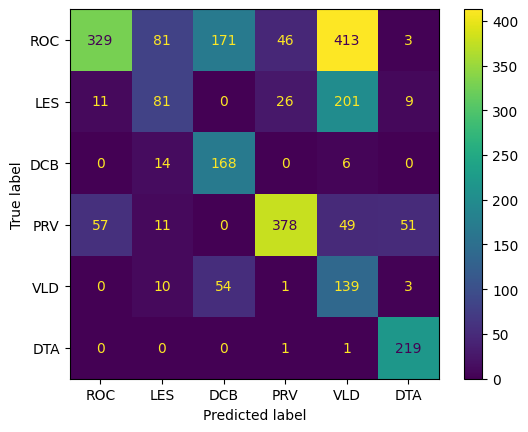

In [11]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, model.predict(test_clean_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD', 'DTA'])
cm_display.plot()
plt.show()

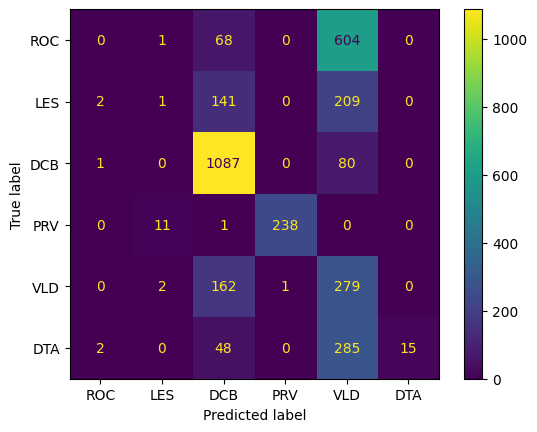

In [12]:
confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, model.predict(test_noisy_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD', 'DTA'])
cm_display.plot()
plt.show()